In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

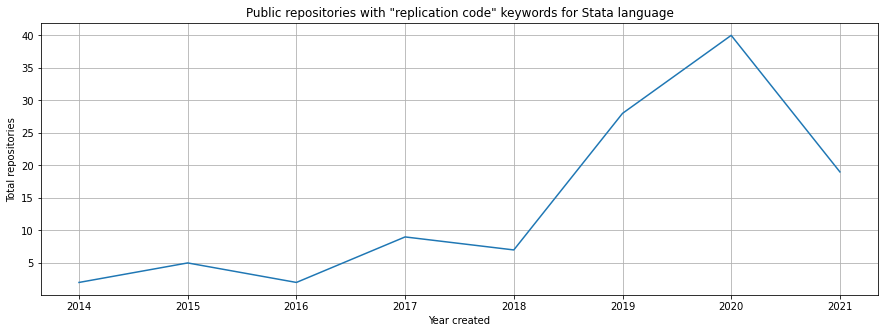

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-06-30 00:56:57: https://www.aeaweb.org/journals/aer/issues
2021-06-30 00:56:58: https://www.aeaweb.org/journals/aeri/issues
2021-06-30 00:57:00: https://www.aeaweb.org/journals/app/issues
2021-06-30 00:57:01: https://www.aeaweb.org/journals/pol/issues
2021-06-30 00:57:02: https://www.aeaweb.org/journals/mac/issues
2021-06-30 00:57:04: https://www.aeaweb.org/journals/mic/issues
2021-06-30 00:57:05: https://www.aeaweb.org/journals/jel/issues
2021-06-30 00:57:06: https://www.aeaweb.org/journals/jep/issues
2021-06-30 00:57:08: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

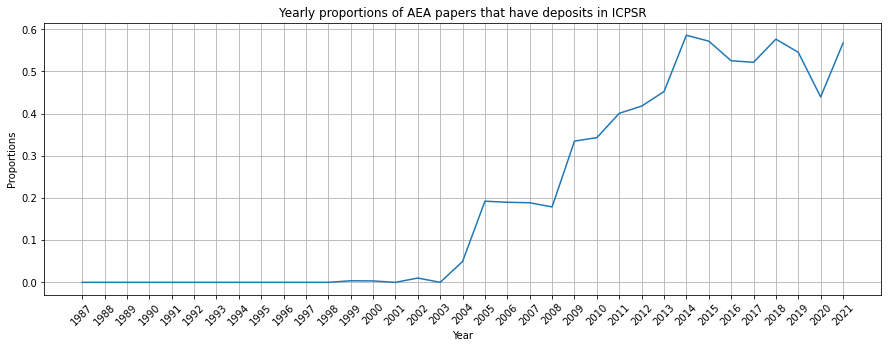

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-06-30 00:57:11: http://dx.doi.org/10.1093/qje/qjy014
2021-06-30 00:57:15: http://dx.doi.org/10.1162/qjec.2007.122.4.1721
2021-06-30 00:57:18: http://dx.doi.org/10.1093/qje/qjv033
2021-06-30 00:57:21: http://dx.doi.org/10.1093/qje/qjz019
2021-06-30 00:57:23: http://dx.doi.org/10.1093/qje/qjr052
2021-06-30 00:57:27: http://dx.doi.org/10.1162/qjec.2010.125.1.445
2021-06-30 00:57:29: http://dx.doi.org/10.1162/qjec.122.2.729
2021-06-30 00:57:33: http://dx.doi.org/10.1162/00335530360698441
2021-06-30 00:57:36: http://dx.doi.org/10.1093/qje/qju026
2021-06-30 00:57:38: http://dx.doi.org/10.1093/qje/qjx048
2021-06-30 00:57:41: http://dx.doi.org/10.1093/qje/qjy031
2021-06-30 00:57:43: http://dx.doi.org/10.1093/qje/qjz033
2021-06-30 00:57:46: http://dx.doi.org/10.1162/qjec.2009.124.1.399
2021-06-30 00:57:48: http://dx.doi.org/10.1162/qjec.2010.125.2.483
2021-06-30 00:57:51: http://dx.doi.org/10.1162/003355303321675473
2021-06-30 00:57:53: http://dx.doi.org/10.1162/qjec.122.1.243
2021-06-30 0

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-06-30 01:05:00: http://dx.doi.org/10.1086/669786
2021-06-30 01:05:02: http://dx.doi.org/10.1086/597328
2021-06-30 01:05:05: http://dx.doi.org/10.1086/650478
2021-06-30 01:05:06: http://dx.doi.org/10.1086/700764
2021-06-30 01:05:08: http://dx.doi.org/10.1086/675238
2021-06-30 01:05:10: http://dx.doi.org/10.1086/688175
2021-06-30 01:05:13: http://dx.doi.org/10.1086/591947
2021-06-30 01:05:15: http://dx.doi.org/10.1086/694621
2021-06-30 01:05:17: http://dx.doi.org/10.1086/686734
2021-06-30 01:05:19: http://dx.doi.org/10.1086/514347
2021-06-30 01:05:21: http://dx.doi.org/10.1086/697205
2021-06-30 01:05:23: http://dx.doi.org/10.1086/658497
2021-06-30 01:05:25: http://dx.doi.org/10.1086/711369
2021-06-30 01:05:27: http://dx.doi.org/10.1086/679496
2021-06-30 01:05:28: http://dx.doi.org/10.1086/705553
2021-06-30 01:05:30: http://dx.doi.org/10.1086/669540
2021-06-30 01:05:32: http://dx.doi.org/10.1086/599706
2021-06-30 01:05:35: http://dx.doi.org/10.1086/696273
2021-06-30 01:05:36: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-06-30 01:24:31: http://dx.doi.org/10.1007/s10887-018-09161-z
2021-06-30 01:24:32: http://dx.doi.org/10.1007/s10887-006-9007-6
2021-06-30 01:24:34: http://dx.doi.org/10.1007/s10887-009-9042-1
2021-06-30 01:24:36: http://dx.doi.org/10.1007/s10887-009-9046-x
2021-06-30 01:24:38: http://dx.doi.org/10.1007/s10887-009-9043-0
2021-06-30 01:24:39: http://dx.doi.org/10.1007/s10887-016-9127-6
2021-06-30 01:24:41: http://dx.doi.org/10.1007/s10887-014-9105-9
2021-06-30 01:24:44: http://dx.doi.org/10.1007/s10887-013-9098-9
2021-06-30 01:24:46: http://dx.doi.org/10.1007/s10887-017-9146-y
2021-06-30 01:24:48: http://dx.doi.org/10.1007/s10887-006-9006-7
2021-06-30 01:24:49: http://dx.doi.org/10.1007/s10887-007-9018-y
2021-06-30 01:24:51: http://dx.doi.org/10.1007/s10887-009-9039-9
2021-06-30 01:24:52: http://dx.doi.org/10.1007/s10887-020-09185-4
2021-06-30 01:24:55: http://dx.doi.org/10.1007/s10887-013-9087-z
2021-06-30 01:24:57: http://dx.doi.org/10.1007/s10887-010-9051-0
2021-06-30 01:24:58: ht

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-06-30 01:30:18: http://dx.doi.org/10.1093/rfs/hhx140
<Response [200]>
2021-06-30 01:30:19: http://dx.doi.org/10.1093/rfs/hhz054
<Response [200]>
2021-06-30 01:30:20: http://dx.doi.org/10.1093/rfs/hhu023
<Response [200]>
2021-06-30 01:30:22: http://dx.doi.org/10.1093/rfs/hhy055
<Response [200]>
2021-06-30 01:30:23: http://dx.doi.org/10.1093/rfs/hhy073
<Response [200]>
2021-06-30 01:30:24: http://dx.doi.org/10.1093/rfs/hhv024
<Response [200]>
2021-06-30 01:30:25: http://dx.doi.org/10.1093/rfs/hhv017
<Response [200]>
2021-06-30 01:30:25: http://dx.doi.org/10.1093/rfs/hht009
<Response [200]>
2021-06-30 01:30:26: http://dx.doi.org/10.1093/rfs/hhw001
<Response [200]>
2021-06-30 01:30:27: http://dx.doi.org/10.1093/rfs/hhs068
<Response [200]>
2021-06-30 01:30:28: http://dx.doi.org/10.1093/rfs/hhy111
<Response [200]>
2021-06-30 01:30:29: http://dx.doi.org/10.1093/rfs/hhz131
<Response [200]>
2021-06-30 01:30:29: http://dx.doi.org/10.1093/rfs/hhw072
<Response [200]>
2021-06-30 01:30:30: http

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-06-30 01:36:24: http://dx.doi.org/10.3982/ecta16173
2021-06-30 01:36:27: http://dx.doi.org/10.3982/ecta14835
2021-06-30 01:36:29: http://dx.doi.org/10.3982/ecta18508
2021-06-30 01:36:32: http://dx.doi.org/10.3982/ecta14176
2021-06-30 01:36:35: http://dx.doi.org/10.3982/ecta13777
2021-06-30 01:36:38: http://dx.doi.org/10.3982/ecta15463
2021-06-30 01:36:40: http://dx.doi.org/10.3982/ecta13615
2021-06-30 01:36:43: http://dx.doi.org/10.3982/ecta14866
2021-06-30 01:36:46: http://dx.doi.org/10.3982/ecta10017
2021-06-30 01:36:47: http://dx.doi.org/10.3982/ecta17489
2021-06-30 01:36:49: http://dx.doi.org/10.3982/ecta17440
2021-06-30 01:36:52: http://dx.doi.org/10.3982/ecta16768
2021-06-30 01:36:55: http://dx.doi.org/10.3982/ecta17260
2021-06-30 01:36:58: http://dx.doi.org/10.3982/ecta16039
2021-06-30 01:37:00: http://dx.doi.org/10.3982/ecta12576
2021-06-30 01:37:01: http://dx.doi.org/10.3982/ecta18788
2021-06-30 01:37:05: http://dx.doi.org/10.3982/ecta15579
2021-06-30 01:37:07: http://dx.

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)